# Notebook for generating plots

In [116]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample

from functions import OLS_parameters
from functions import Ridge_parameters
from functions import Find_MSE_Ridge_predict_poly_ridgelambda
from functions import Polynomial_Features

from runge_function import Runge_func

In [117]:
np.random.seed(2025)

n = 100
x = np.linspace(-1, 1, n)
# The Runge func with noise
y = Runge_func(x) + np.random.normal(0, 1, size=n)

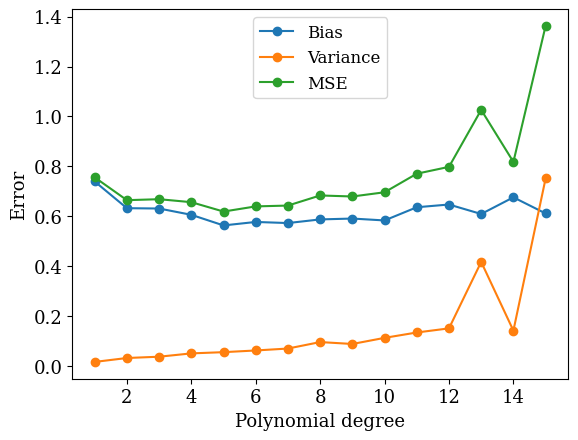

In [118]:
# Bias-variance-tradeoff

bootstraps = 100

x = x.reshape(-1,1)
y = y.reshape(-1,1)

max_degree = 15
poly_degrees = np.arange(1, max_degree + 1, 1)

biases = np.zeros(max_degree)
variances = np.zeros(max_degree)
MSEs = np.zeros(max_degree)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

for degree in range(len(poly_degrees)):
    X_train = Polynomial_Features(x_train.ravel(), poly_degrees[degree], intercept=True)
    X_test = Polynomial_Features(x_test.ravel(), poly_degrees[degree], intercept=True)

    # predictions are later filled with predictions made from X_test (feature matrix), constructed from x_test, 
    # so got to have same length
    predictions = np.zeros([bootstraps, len(x_test)])

    for b in range(bootstraps):
        # For each bootstrap sample of X_train and Y_train, we train model, predict on X_test
        # Later comparing against the un-touched y_test

        X_train_resampled, y_train_resampled = resample(X_train, y_train)
        beta_OLS = OLS_parameters(X_train_resampled, y_train_resampled)
        predictions[b,:] = (X_test @ beta_OLS).ravel()

    # We take the true values or target, as the un-tough values in the y_test split
    # The predicted y values, lives in the predictions matrix, where each row is a sample of values,
    # and each column corresponding to a one y point across bootstrap samples 
    biases[degree] = np.mean((y_test.ravel() - np.mean(predictions, axis=0))**2)

    # Var(prediction) is the mean of the flatend matrix, over all samples
    variances[degree] = np.mean((predictions - np.mean(predictions, axis=0))**2)

    # For the MSE, we take difference of each y point per bootstrap sample, making y_test a row vector
    # then squaring, before taking the mean over the flattened matrix
    
    MSEs[degree] = np.mean(np.mean((predictions - y_test.ravel())**2, axis=1), axis=0)

plt.rcParams.update({
    'text.usetex': False,           # Use mathtext instead of full LaTeX
    'font.family': 'serif',
    'font.size': 13,
    'axes.titlesize': 13,
    'axes.labelsize': 13,
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
    'legend.fontsize': 12,
})

plt.plot(poly_degrees, biases, 'o-', label="Bias", alpha=1.0)
plt.plot(poly_degrees, variances, 'o-', label="Variance", alpha=1.0)
plt.plot(poly_degrees, MSEs, 'o-', label="MSE", alpha=1.0)
#plt.title(f"Bias-variance tradeoff, for {n} data points and {bootstraps} bootstraps")
plt.xlabel("Polynomial degree")
plt.ylabel("Error")
plt.legend(loc="upper center")
plt.savefig("bias_var_tradeoff.pdf", bbox_inches="tight")
plt.show()
plt.close()

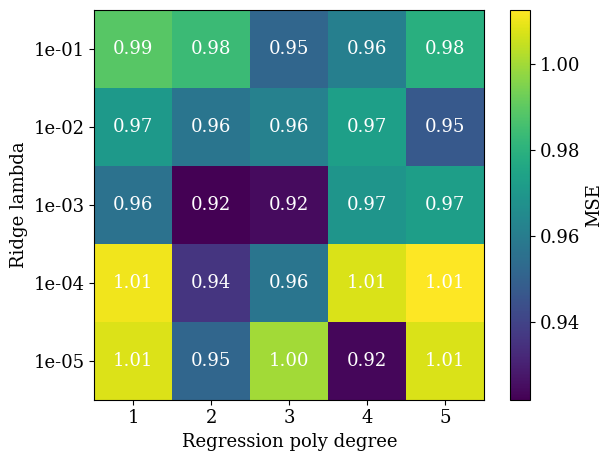

In [105]:
# Heatmap Ridge

poly_min = 1
poly_max = 5
poly_degrees = np.arange(poly_min, poly_max + 1, 1)

exp_start = -1
exp_stop = -5
ridge_lambdas = np.logspace(exp_start, exp_stop, abs(exp_stop-exp_start)+1) # takes 1e(exp_start) and 1e(exp_stop) as arguments, 1e1 as steps

runs = 100    # Numbers of times we calculate the MSE matrix
MSE_polys_ridgelambdas_matrix = np.zeros((len(ridge_lambdas), len(poly_degrees), runs)) # 3d array, each run store the poly-lambda-plane

for k in range(runs):
    for j in range(len(poly_degrees)):
        for i in range(len(ridge_lambdas)):
            MSE_Ridge_poly_ridgelambda = Find_MSE_Ridge_predict_poly_ridgelambda(x.ravel(), y, poly_degrees[j], ridge_lambdas[i])
            MSE_polys_ridgelambdas_matrix[i,j,k] = MSE_Ridge_poly_ridgelambda


# Taking the mean over all the runs, element vise
mean_MSE = np.copy(np.mean(MSE_polys_ridgelambdas_matrix, axis=2))

# Creating heatmap, copied from from Copilot answers and tweaked

fig, ax = plt.subplots()

# Display the heatmap using the Axes object
im = ax.imshow(mean_MSE, cmap='viridis', interpolation='nearest')

# Annotate each cell with its value
for i in range(mean_MSE.shape[0]):
    for j in range(mean_MSE.shape[1]):
        value = mean_MSE[i, j]
        ax.text(j, i, f"{value:.2f}", ha="center", va="center", color="white")

# Set axis ticks and labels
ax.set_xticks(np.arange(len(poly_degrees)))
ax.set_xticklabels(poly_degrees)
ax.set_yticks(np.arange(len(ridge_lambdas)))
ax.set_yticklabels([f"{lam:.0e}" for lam in ridge_lambdas])

# Add colorbar and labels
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('MSE')

#ax.set_title(f"MSE for Ridge regression, averaged over {runs} runs")
ax.set_xlabel("Regression poly degree")
ax.set_ylabel("Ridge lambda")

plt.tight_layout()

# Make plot latex report friendly
plt.rcParams.update({
    'text.usetex': False,
    'font.family': 'serif',
    'font.size': 13,
    'axes.titlesize': 13,
    'axes.labelsize': 13,
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
    'legend.fontsize': 12,
})

plt.savefig("heatmap_ridge.pdf", bbox_inches="tight")
plt.show()
plt.close()